## Import Libraries

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from catboost import CatBoostClassifier

## Load Data

In [57]:
changeJobDf = pd.read_csv('A2_change_job_labeled.csv')

## EDA

In [58]:
print("--- Dataset Overview ---")
changeJobDfCount = changeJobDf.shape[0]
print(f"Number of training data rows: {changeJobDfCount}...")

print("\n--- Checking for null values ---")
missingCount = changeJobDf.isna().sum()
missingCount = len(missingCount[missingCount > 1])
print(f"Missing values in train df: {missingCount}...")

print("\n--- Checking for empty/whitespace-only reviews ---")
emptyCountTrainCount = changeJobDf.eq('').sum()
emptyCountTrainCount = len(emptyCountTrainCount[emptyCountTrainCount > 1])
print(f"Number of empty/whitespace-only reviews: {emptyCountTrainCount}...")

print("\n--- Checking for duplicates ---")
duplicateRowCount = changeJobDf.duplicated().sum()
print(f"Number of duplicate rows: {duplicateRowCount}...")

--- Dataset Overview ---
Number of training data rows: 11494...

--- Checking for null values ---
Missing values in train df: 0...

--- Checking for empty/whitespace-only reviews ---
Number of empty/whitespace-only reviews: 0...

--- Checking for duplicates ---
Number of duplicate rows: 0...


## Check Depndendent/Target Variable Distribution

Target distribution: target
no     8676
yes    2818
Name: count, dtype: int64


Text(0, 0.5, 'Count')

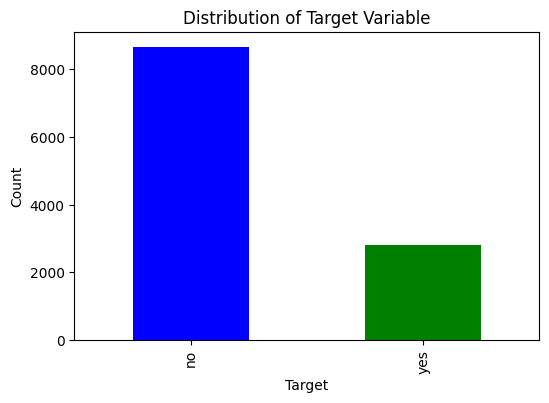

In [59]:
# Calculate value counts
targetCounts = changeJobDf['target'].value_counts()
print(f"Target distribution: {targetCounts}")

# Create the plot
plt.figure(figsize=(6, 4))

# Use a bar chart
targetCounts.plot(kind='bar', color=['Blue', 'Green'])
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')

## Remove Field

In [60]:
jobChangeDfTest = pd.read_csv('A2_change_job_submission.csv')
cidTestDf = pd.merge(jobChangeDfTest,changeJobDf,how='inner',on='cid')

# If cid empty then there are no overlapping ID's between test and train
if cidTestDf.empty:
    changeJobDf = changeJobDf.drop(columns='cid')

## Check unique values for non numeric fields

In [61]:
nonNumericCols = changeJobDf.select_dtypes(exclude=[np.number]).columns
print("--- Non-numeric Field Unique Values ---")
for col in nonNumericCols:
    print(f"{col}: {changeJobDf[col].unique()}")

--- Non-numeric Field Unique Values ---
gender: ['Male' 'Other' 'Female']
enrolled_university: ['No enrollment' 'Full time' 'Part time']
education_level: ['Undergraduate' 'High School' 'PhD' 'Primary School' 'Masters']
academic_discipline: ['STEM' 'No major' 'Humanities' 'Other' 'Business degree' 'Arts']
experience: ['15' '4' '8' '2' '7' '5' '13' '3' '6' '19' '>20' '1' '16' '20' '10' '<1'
 '9' '11' '18' '14' '17' '12']
company_size: ['100-500' '50-99' '5000-9999' '500-999' '10000+' '<10' 'Oct-49'
 '1000-4999']
company_type: ['NGO' 'Funded startup' 'Pvt Ltd' 'Public sector' 'Early stage startup'
 'Other']
last_new_job: ['1' '>4' 'never' '2' '4' '3']
relevant_experience: ['Has relevant experience' 'No relevant experience']
target: ['no' 'yes']


## Create Ordinal Mappings

In [62]:
# Ordinal mappings
companySizeMap = {'<10': 0, 'Oct-49': 1, '50-99': 2, '100-500': 3, '500-999': 4, '1000-4999': 5, '5000-9999': 6, '10000+': 7}
lastNewJobMap = {'never': 0, '1': 1, '2': 2, '3': 3, '4': 4, '>4': 5}
educationMap = {'Primary School': 0, 'High School': 1, 'Undergraduate': 2, 'Masters': 3, 'PhD': 4}
changeJobDf['company_size'] = changeJobDf['company_size'].map(companySizeMap)
changeJobDf['last_new_job'] = changeJobDf['last_new_job'].map(lastNewJobMap)
changeJobDf['education_level'] = changeJobDf['education_level'].map(educationMap)

# Target
targetMap = {'no': 0, 'yes': 1}
changeJobDf['target'] = changeJobDf['target'].map(targetMap)

# Define ordinal cols and create a list of non-numeric cols without ordinals
colsToIgnore = ['company_size','last_new_job','education_level','target']
labelEncodeCols = [col for col in nonNumericCols if col not in colsToIgnore]

# Transform categorical columns
le = preprocessing.LabelEncoder()

# Apply transformations
for col in labelEncodeCols:
    changeJobDf[col] = le.fit_transform(changeJobDf[col])

print("--- Non-numeric Field Post Transformation Values ---")
for col in nonNumericCols:
    print(f"{col}: {changeJobDf[col].unique()}")

--- Non-numeric Field Post Transformation Values ---
gender: [1 2 0]
enrolled_university: [1 0 2]
education_level: [2 1 4 0 3]
academic_discipline: [5 3 2 4 1 0]
experience: [ 6 14 18 11 17 15  4 13 16 10 21  0  7 12  1 20 19  2  9  5  8  3]
company_size: [3 2 6 4 7 0 1 5]
company_type: [2 1 5 4 0 3]
last_new_job: [1 5 0 2 4 3]
relevant_experience: [0 1]
target: [0 1]


## Seperate Feature cols and target col

In [63]:
targetCol = changeJobDf.columns[-1]
featureCols = changeJobDf.columns[:-1]

In [64]:
changeJobDf

,city.100,city.10,city.105,city.103,city.104,city.102,city.101,city.2119,city.114,city.2341,...,education_level,academic_discipline,experience,company_size,company_type,last_new_job,city_development_index,relevant_experience,training_hours,target
0,0,0,0,0,0,0,0,0,0,0,...,2,5,6,3,2,1,0.942116,0,21,0
1,0,0,1,0,0,0,0,0,0,0,...,2,5,14,2,1,1,0.219561,1,92,1
2,0,0,0,0,0,0,0,0,0,0,...,1,5,18,2,5,5,0.499002,0,21,0
3,0,0,0,0,0,0,0,0,0,0,...,2,5,11,2,5,0,0.351297,1,114,0
4,0,0,0,0,0,0,0,0,0,0,...,4,5,17,6,4,1,0.626747,0,24,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11489,0,0,0,0,1,0,0,0,0,0,...,2,5,7,3,5,1,0.942116,0,72,0
11490,0,0,0,0,1,0,0,0,0,0,...,2,0,19,0,2,1,0.942116,0,37,0
11491,0,0,0,0,1,0,0,0,0,0,...,2,5,21,3,5,2,0.942116,0,4,0
11492,0,0,0,0,0,0,0,0,0,0,...,2,5,14,3,5,0,0.351297,1,70,1


## Correaltion Analysis

In [65]:
corrMatrix = changeJobDf.corr()
targetCorr = corrMatrix[targetCol].sort_values(ascending=False)
targetCorr = targetCorr.drop(labels=[targetCol]) # Excluding target from matrix as this is redundant

print(f"--- Top features positively correlated with {targetCol} ---")
print(targetCorr.head(10))

print(f"\n --- Top features negatively correlated with {targetCol} --- ")
print(targetCorr.tail(10))

--- Top features positively correlated with target ---
city.326               0.322135
relevant_experience    0.138455
city.2119              0.084905
city.128               0.065363
city.142               0.062480
city.105               0.043956
city.74                0.041877
company_size           0.039761
city.2341              0.032755
city.699               0.030747
Name: target, dtype: float64

 --- Top features negatively correlated with target --- 
city.102                 -0.043070
city.328                 -0.043381
city.104                 -0.046510
company_type             -0.051647
city.134                 -0.057197
last_new_job             -0.082293
city.96                  -0.084513
city.114                 -0.096497
enrolled_university      -0.132326
city_development_index   -0.345993
Name: target, dtype: float64


## Mutual Information Score

/Users/mathiasmorgan/Desktop/Applied Data Science/ITO5149 - Applied Data Analysis/Assessment 2/A2_data_demo_code/venv/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


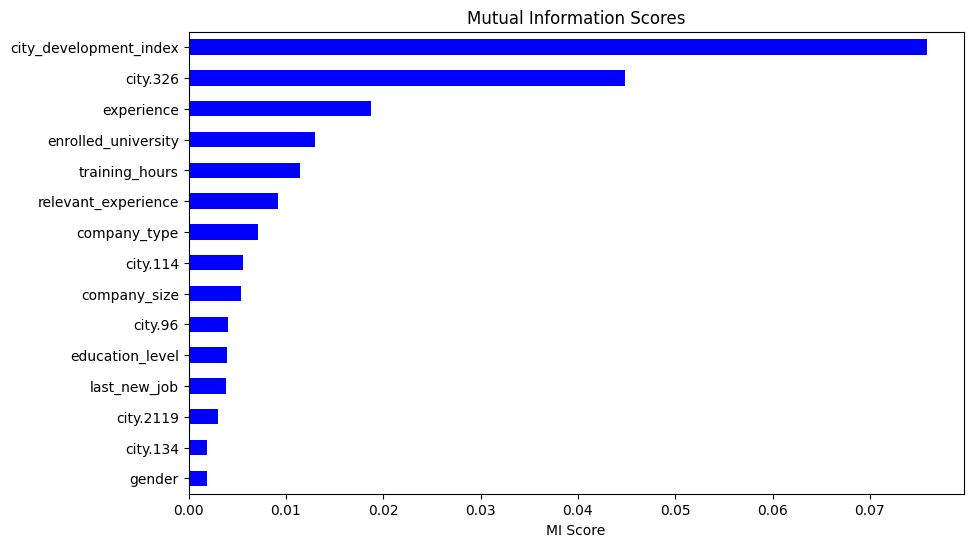

In [66]:
miScores = mutual_info_classif(changeJobDf[featureCols], changeJobDf[targetCol], discrete_features=True, random_state=42)
miSeries = pd.Series(miScores, index=changeJobDf[featureCols].columns)
miSeries = miSeries.sort_values(ascending=False)

# 4. Plot
plt.figure(figsize=(10, 6))
miSeries.head(15).plot(kind='barh', color='blue')
plt.title("Mutual Information Scores")
plt.xlabel("MI Score")
plt.gca().invert_yaxis()
plt.show()

## Modelling

In [67]:
# Pre-processing
x = changeJobDf[featureCols]
y = changeJobDf[targetCol]

### Functions

In [69]:
def plot_feature_importance(model, featureNames, topN):
    imp = pd.Series(model.feature_importances_, index=featureNames)
    imp.nlargest(topN).sort_values().plot(kind='barh', figsize=(10, 6), title="Feature Importance")
    plt.show()

def plot_confusion_matrix(yTrue, yPred, labels=["No", "Yes"]):
    cm = confusion_matrix(yTrue, yPred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()

## XGBoost

Class Imbalance Ratio: 3.08

--- Baseline Performance - All Features ---
F1 Score: 0.5539

--- Top 30 Feature Importances ---


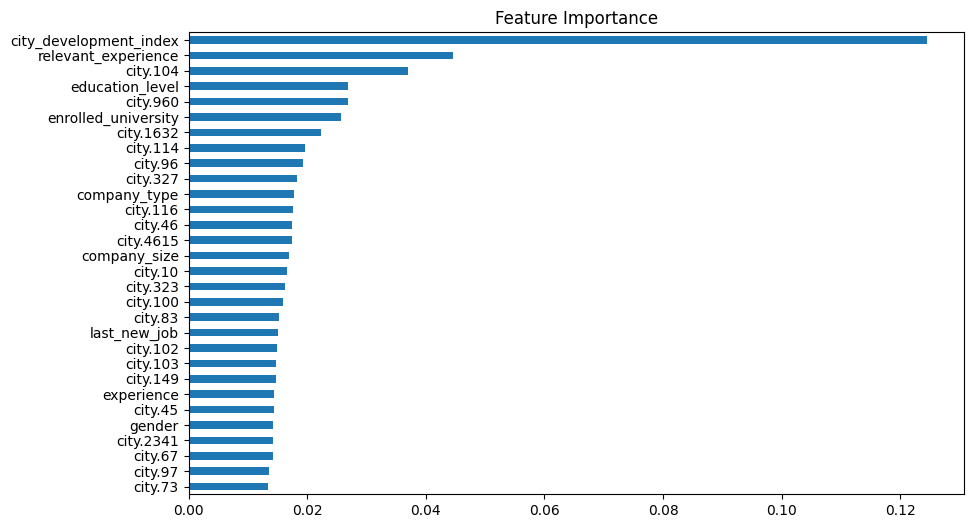


--- Comparing Baseline and Trimmed Model ---
Top 30 Features selected: ['city_development_index', 'relevant_experience', 'city.104', 'education_level', 'city.960', 'enrolled_university', 'city.1632', 'city.114', 'city.96', 'city.327', 'company_type', 'city.116', 'city.46', 'city.4615', 'company_size', 'city.10', 'city.323', 'city.100', 'city.83', 'last_new_job', 'city.102', 'city.103', 'city.149', 'experience', 'city.45', 'gender', 'city.2341', 'city.67', 'city.97', 'city.73']
Baseline F1: 0.5539
Trimmed F1:  0.5515
>>> Applying TRIMMED Model - Top 30 features

--- Starting Hyperparameter Tuning (Grid Search) ---
Tuning on (9195, 30) features...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'scale_pos_weight': 3.0}
Best CV F1 Score: 0.5692

--- Final Test Set Performance ---
F1 Score: 0.5805

Confusion Matrix:


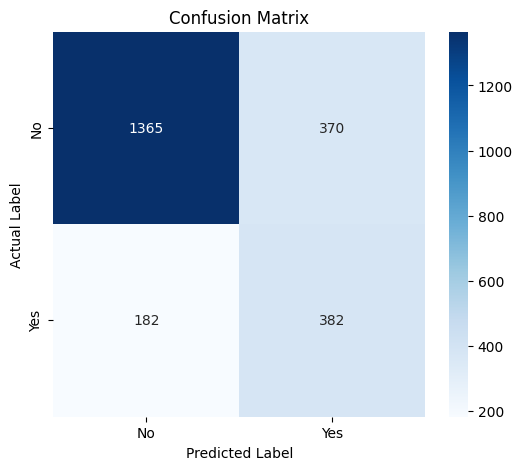

In [70]:
# --- STEP 1: Data Split and Hold out Set ---

# Split train set
xTrainFull, xTest, yTrainFull, yTest = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

# Create hold out set
xTrain, xVal, yTrain, yVal = train_test_split(
    xTrainFull, yTrainFull, test_size=0.2, random_state=42, stratify=yTrainFull
)

# 3. Calculate imbalance ration between No and Yes values in data set
imbalanceRatio = float(np.sum(yTrain == 0)) / np.sum(yTrain == 1)
print(f"Class Imbalance Ratio: {imbalanceRatio:.2f}")

# --- STEP 2: Baseline XGBoost Model ---

xgbModel = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=imbalanceRatio,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    early_stopping_rounds=50,
)

# Fit model
xgbModel.fit(xTrain, yTrain, eval_set=[(xVal, yVal)], verbose=False)

# Evaluate baseline
yValPred = xgbModel.predict(xVal)
f1Val = f1_score(yVal, yValPred)

print(f"\n--- Baseline Performance - All Features ---")
print(f"F1 Score: {f1Val:.4f}")

# --- STEP 3: Visualise Information Gain ---

# Plot features
print("\n--- Top 30 Feature Importances ---")
plot_feature_importance(xgbModel, xTrain.columns, topN=30)

# --- STEP 4: Model Selection ---

print("\n--- Comparing Baseline and Trimmed Model ---")

# Extract top 30 features by information gain
importanceMap = xgbModel.get_booster().get_score(importance_type="gain")
sortedFeatures = sorted(importanceMap.items(), key=lambda item: item[1], reverse=True)[:30]
top30Features = [k for k, _ in sortedFeatures]
print(f"Top 30 Features selected: {top30Features}")

# Create Trimmed Datasets
xTrainTrimmed = xTrain[top30Features]
xValTrimmed = xVal[top30Features]

# Train Trimmed Model
xgbTrimmed = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=imbalanceRatio,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    early_stopping_rounds=50,
)

xgbTrimmed.fit(xTrainTrimmed, yTrain, eval_set=[(xValTrimmed, yVal)], verbose=False)

# Evaluate Trimmed
yValPredTrimmed = xgbTrimmed.predict(xValTrimmed)
f1Trimmed = f1_score(yVal, yValPredTrimmed)

print(f"Baseline F1: {f1Val:.4f}")
print(f"Trimmed F1:  {f1Trimmed:.4f}")

# Conditional logic to determine model selection
if f1Trimmed >= (f1Val - 0.01):
    print(">>> Applying TRIMMED Model - Top 30 features")

    # Overwrite variables with top 30 features
    xTrainFull = xTrainFull[top30Features]
    xTest = xTest[top30Features]
else:
    print(">>> Applying BASELINE Model - All features")

# --- STEP 5: Hyperparamter Tuning ---

print("\n--- Starting Hyperparameter Tuning (Grid Search) ---")
print(f"Tuning on {xTrainFull.shape} features...")

# param grid
paramGrid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "scale_pos_weight": [imbalanceRatio, 1],
    "n_estimators": [100, 200],
    "min_child_weight": [1, 3, 5],
    "scale_pos_weight": [imbalanceRatio, 1, 3.0]
}

xgbGrid = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
)

gridSearch = GridSearchCV(
    estimator=xgbGrid,
    param_grid=paramGrid,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
)

# fit best params
gridSearch.fit(xTrainFull, yTrainFull)

print(f"Best Parameters: {gridSearch.best_params_}")
print(f"Best CV F1 Score: {gridSearch.best_score_:.4f}")

# --- STEP 6: Final Evaluation on Test Set ---

bestModel = gridSearch.best_estimator_
yTestPred = bestModel.predict(xTest)

print("\n--- Final Test Set Performance ---")
print(f"F1 Score: {f1_score(yTest, yTestPred):.4f}")

print("\nConfusion Matrix:")
plot_confusion_matrix(yTest, yTestPred, labels=["No", "Yes"])

## Cat Boost

Class Imbalance Ratio: 3.08

--- Baseline Performance (All Features) ---
F1 Score: 0.5503

--- Top 30 Feature Importances ---


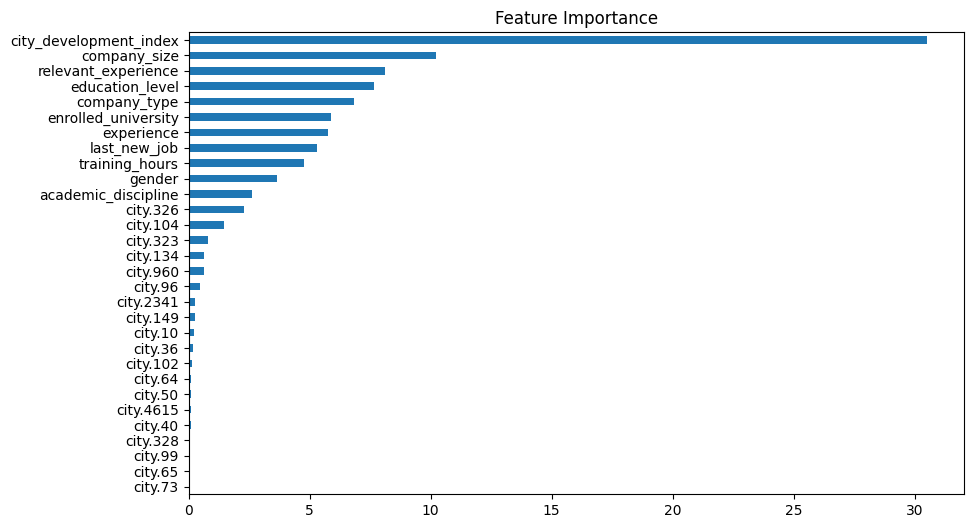


--- Comparing Baseline and Trimmed Model ---
Top 30 Features selected: ['city_development_index', 'company_size', 'relevant_experience', 'education_level', 'company_type', 'enrolled_university', 'experience', 'last_new_job', 'training_hours', 'gender', 'academic_discipline', 'city.326', 'city.104', 'city.323', 'city.134', 'city.960', 'city.96', 'city.2341', 'city.149', 'city.10', 'city.36', 'city.102', 'city.64', 'city.50', 'city.4615', 'city.40', 'city.328', 'city.99', 'city.65', 'city.73']
Baseline F1: 0.5503
Trimmed F1:  0.5506
>>> Applying TRIMMED Model - Top 30 features

--- Starting Hyperparameter Tuning (Grid Search) ---
Tuning on 30 features...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'depth': 5, 'iterations': 100, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'scale_pos_weight': np.float64(3.0798668885191347)}
Best CV F1 Score: 0.5735

--- Final Test Set Performance ---
F1 Score: 0.5759

Confusion Matrix:


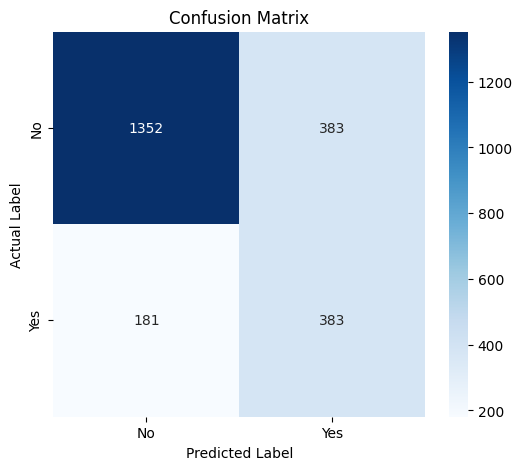

In [71]:
# --- STEP 1: Data Split and Hold out Set ---

# Split train set
xTrainFull, xTest, yTrainFull, yTest = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# Create hold out set
xTrain, xVal, yTrain, yVal = train_test_split(
    xTrainFull, yTrainFull, test_size=0.2, random_state=42, stratify=yTrainFull
)

# 3. Calculate imbalance ration between No and Yes values in data sett
imbalanceRatio = float(np.sum(yTrain == 0)) / np.sum(yTrain == 1)
print(f"Class Imbalance Ratio: {imbalanceRatio:.2f}")

# --- STEP 2: Baseline CatBoost Model ---

cbModel = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="Logloss",
    scale_pos_weight=imbalanceRatio,
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    early_stopping_rounds=50,
    verbose=0,
    allow_writing_files=False,
)

# Fit Model
cbModel.fit(xTrain, yTrain, eval_set=[(xVal, yVal)])

# Evaluate baseline
yValPred = cbModel.predict(xVal)
f1Val = f1_score(yVal, yValPred)

print(f"\n--- Baseline Performance (All Features) ---")
print(f"F1 Score: {f1Val:.4f}")

# --- STEP 3: Visualise Information Gain ---

# Plot features
print("\n--- Top 30 Feature Importances ---")
plot_feature_importance(cbModel, xTrain.columns, topN=30)

# --- STEP 4: Model Selection ---

print("\n--- Comparing Baseline and Trimmed Model ---")

# Extract top 30 features by information gain
feature_importances = cbModel.feature_importances_
feature_names = xTrain.columns

# Extract top 30 features by information gain
sortedFeatures = sorted(
    zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True
)[:30]
top30Features = [k for k, _ in sortedFeatures]

print(f"Top 30 Features selected: {top30Features}")

# Create Trimmed Datasets
xTrainTrimmed = xTrain[top30Features]
xValTrimmed = xVal[top30Features]

# Train Trimmed Model
cbTrimmed = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="Logloss",
    scale_pos_weight=imbalanceRatio,
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    early_stopping_rounds=50,
    verbose=0,
    allow_writing_files=False,
)

cbTrimmed.fit(xTrainTrimmed, yTrain, eval_set=[(xValTrimmed, yVal)])

# Evaluate Trimmed
yValPredTrimmed = cbTrimmed.predict(xValTrimmed)
f1Trimmed = f1_score(yVal, yValPredTrimmed)

print(f"Baseline F1: {f1Val:.4f}")
print(f"Trimmed F1:  {f1Trimmed:.4f}")

# Conditional logic to determine model selection
if f1Trimmed >= (f1Val - 0.01):
    print(">>> Applying TRIMMED Model - Top 30 features")

    # Overwrite variables with top 30 features
    xTrainFull = xTrainFull[top30Features]
    xTest = xTest[top30Features]
else:
    print(">>> Applying BASELINE Model - All features")

# --- STEP 5: Hyperparamter Tuning ---

print("\n--- Starting Hyperparameter Tuning (Grid Search) ---")
print(f"Tuning on {xTrainFull.shape[1]} features...")

# param grid
paramGrid = {
    "depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "iterations": [100, 200],
    "l2_leaf_reg": [1, 3, 5],
    "scale_pos_weight": [imbalanceRatio, 1, 3.0]
}

cbGrid = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="Logloss",
    random_seed=42,
    verbose=0,
    allow_writing_files=False,
)

gridSearch = GridSearchCV(
    estimator=cbGrid,
    param_grid=paramGrid,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
)

# fit best params
gridSearch.fit(xTrainFull, yTrainFull)

print(f"Best Parameters: {gridSearch.best_params_}")
print(f"Best CV F1 Score: {gridSearch.best_score_:.4f}")

# --- STEP 6: Final Evaluation on Test Set ---

bestModel = gridSearch.best_estimator_
yTestPred = bestModel.predict(xTest)

print("\n--- Final Test Set Performance ---")
print(f"F1 Score: {f1_score(yTest, yTestPred):.4f}")

print("\nConfusion Matrix:")
plot_confusion_matrix(yTest, yTestPred, labels=["No", "Yes"])

## Random Forest


--- Baseline Performance (All Features) ---
F1 Score: 0.5451

--- Top 30 Feature Importances ---
                   Feature  Importance
68  city_development_index    0.251462
31                city.326    0.153285
64              experience    0.070392
70          training_hours    0.069978
61     enrolled_university    0.067216
65            company_size    0.060931
69     relevant_experience    0.052431
66            company_type    0.042313
62         education_level    0.040316
67            last_new_job    0.033954
8                 city.114    0.019334
60                  gender    0.017737
63     academic_discipline    0.016117
25                 city.96    0.013969
4                 city.104    0.010532
7                city.2119    0.006080
15                city.134    0.005783
26                city.960    0.004272
32                city.323    0.004081
12                city.128    0.003640
46                 city.67    0.003380
5                 city.102    0.003368
19   

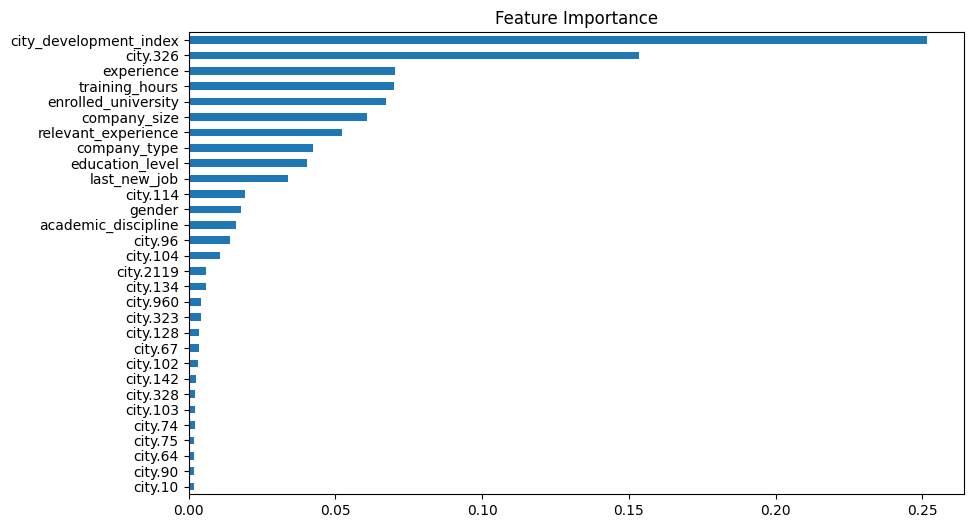


--- Comparing Baseline vs. Trimmed Model ---
Top 30 Features selected: ['city_development_index', 'city.326', 'experience', 'training_hours', 'enrolled_university', 'company_size', 'relevant_experience', 'company_type', 'education_level', 'last_new_job', 'city.114', 'gender', 'academic_discipline', 'city.96', 'city.104', 'city.2119', 'city.134', 'city.960', 'city.323', 'city.128', 'city.67', 'city.102', 'city.142', 'city.328', 'city.103', 'city.74', 'city.75', 'city.64', 'city.90', 'city.10']
Baseline F1: 0.5451
Trimmed F1:  0.5421
>>> Applying TRIMMED Model - Top 30 features

--- Starting Hyperparameter Tuning (Grid Search) ---
Tuning on 30 features...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best CV F1 Score: 0.5674

--- Final Test Set Performance ---
F1 Score: 0.5819

Confusion Matrix:


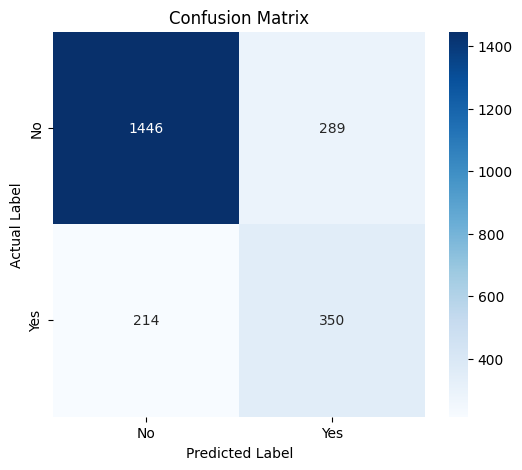

In [72]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

# --- STEP 1: DATA SPLITTING STRATEGY ---

# 1. Split out the FINAL Test set (20%)
xTrainFull, xTest, yTrainFull, yTest = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Create the HOLD-OUT Validation set (20% of the 80%)
xTrain, xVal, yTrain, yVal = train_test_split(
    xTrainFull, yTrainFull, test_size=0.2, random_state=42, stratify=yTrainFull
)

# Note: We don't need manual imbalanceRatio calculation for RF.
# We will use class_weight='balanced' which handles it automatically.

# --- STEP 2: BASELINE RANDOM FOREST MODEL ---

rfModel = RandomForestClassifier(
    n_estimators=200,            # RF needs fewer trees than Boosters usually
    max_depth=10,                # Limit depth to prevent overfitting/slowness
    class_weight="balanced",     # Handles the imbalance
    random_state=42,
    n_jobs=-1                    # USE ALL CORES (Crucial for speed)
)

# Note: No eval_set or early_stopping for standard Random Forest
rfModel.fit(xTrain, yTrain)

# Predict Baseline
yValPred = rfModel.predict(xVal)
f1Val = f1_score(yVal, yValPred)

print(f"\n--- Baseline Performance (All Features) ---")
print(f"F1 Score: {f1Val:.4f}")

# --- STEP 3: VISUALISE INFORMATION GAIN ---

# 1. Text Print Out
importances = rfModel.feature_importances_
feature_df = pd.DataFrame({'Feature': xTrain.columns, 'Importance': importances})
print("\n--- Top 30 Feature Importances ---")
print(feature_df.sort_values(by='Importance', ascending=False).head(30))

# 2. Plotting (Using your function)
plot_feature_importance(rfModel, xTrain.columns, topN=30)

# --- STEP 3.5: MODEL SELECTION (Baseline vs. Top 30) ---

print("\n--- Comparing Baseline vs. Trimmed Model ---")

# 1. Extract Top 30 Feature Names
# RF returns an array, so we zip and sort
feature_names = xTrain.columns
sortedFeatures = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:30]
top30Features = [k for k, _ in sortedFeatures]

print(f"Top 30 Features selected: {top30Features}")

# 2. Create Trimmed Datasets
xTrainTrimmed = xTrain[top30Features]
xValTrimmed = xVal[top30Features]

# 3. Train Trimmed Model
rfTrimmed = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rfTrimmed.fit(xTrainTrimmed, yTrain)

# 4. Evaluate Trimmed
yValPredTrimmed = rfTrimmed.predict(xValTrimmed)
f1Trimmed = f1_score(yVal, yValPredTrimmed)

print(f"Baseline F1: {f1Val:.4f}")
print(f"Trimmed F1:  {f1Trimmed:.4f}")

# 5. THE DECISION SWITCH
if f1Trimmed >= (f1Val - 0.01):
    print(">>> Applying TRIMMED Model - Top 30 features")
    xTrainFull = xTrainFull[top30Features]
    xTest = xTest[top30Features]
else:
    print(">>> Applying BASELINE Model - All features")

# --- STEP 4: HYPERPARAMETER TUNING (Grid Search CV) ---

print("\n--- Starting Hyperparameter Tuning (Grid Search) ---")
print(f"Tuning on {xTrainFull.shape[1]} features...")

# Random Forest Grid
paramGrid = {
    "n_estimators": [100, 300],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "class_weight": ["balanced", "balanced_subsample"]
}

rfGrid = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

gridSearch = GridSearchCV(
    estimator=rfGrid,
    param_grid=paramGrid,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
)

gridSearch.fit(xTrainFull, yTrainFull)

print(f"Best Parameters: {gridSearch.best_params_}")
print(f"Best CV F1 Score: {gridSearch.best_score_:.4f}")

# --- STEP 5: FINAL EVALUATION ON TEST SET ---

bestModel = gridSearch.best_estimator_
yTestPred = bestModel.predict(xTest)

print("\n--- Final Test Set Performance ---")
print(f"F1 Score: {f1_score(yTest, yTestPred):.4f}")

print("\nConfusion Matrix:")
plot_confusion_matrix(yTest, yTestPred, labels=["No", "Yes"])

## Linear SVC


--- Baseline Performance (All Features) ---
F1 Score: 0.5288

--- Top 30 Feature Importances (Absolute Coefficients) ---
                   Feature  Importance
68  city_development_index    0.389380
4                 city.104    0.198248
69     relevant_experience    0.132087
26                city.960    0.104968
31                city.326    0.100431
65            company_size    0.095383
66            company_type    0.068562
25                 city.96    0.057032
61     enrolled_university    0.056427
13               city.2194    0.046845
62         education_level    0.045980
1                  city.10    0.042731
54                 city.89    0.040814
51                 city.75    0.038398
8                 city.114    0.035632
9                city.2341    0.034753
70          training_hours    0.034659
44                 city.64    0.031597
28                city.665    0.029117
48                city.798    0.028611
22               city.1532    0.026761
6                 ci

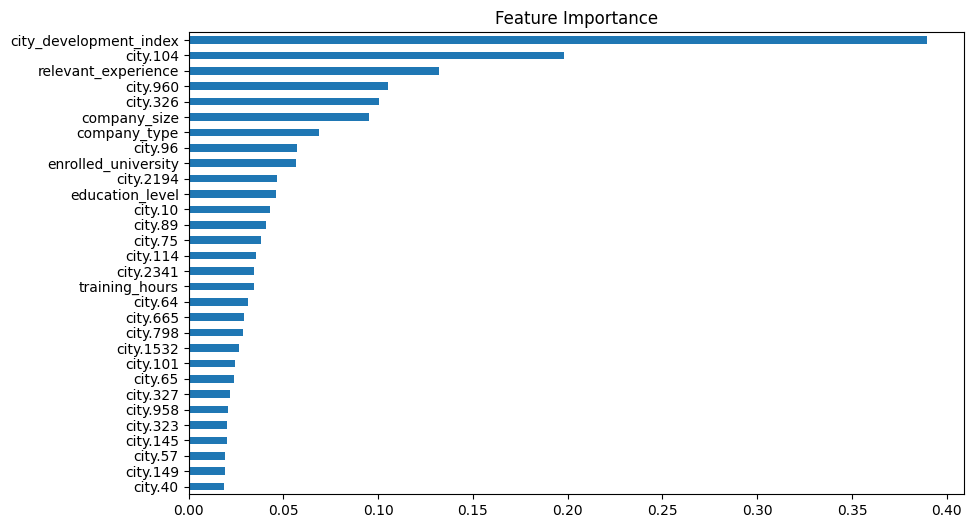


--- Comparing Baseline vs. Trimmed Model ---
Top 30 Features selected: ['city_development_index', 'city.104', 'relevant_experience', 'city.960', 'city.326', 'company_size', 'company_type', 'city.96', 'enrolled_university', 'city.2194', 'education_level', 'city.10', 'city.89', 'city.75', 'city.114', 'city.2341', 'training_hours', 'city.64', 'city.665', 'city.798', 'city.1532', 'city.101', 'city.65', 'city.327', 'city.958', 'city.323', 'city.145', 'city.57', 'city.149', 'city.40']
Baseline F1: 0.5288
Trimmed F1:  0.5298
>>> Applying TRIMMED Model - Top 30 features

--- Starting Hyperparameter Tuning (Grid Search) ---
Tuning on 30 features...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': 0.01, 'class_weight': 'balanced'}
Best CV F1 Score: 0.5491

--- Final Test Set Performance ---
F1 Score: 0.5616

Confusion Matrix:


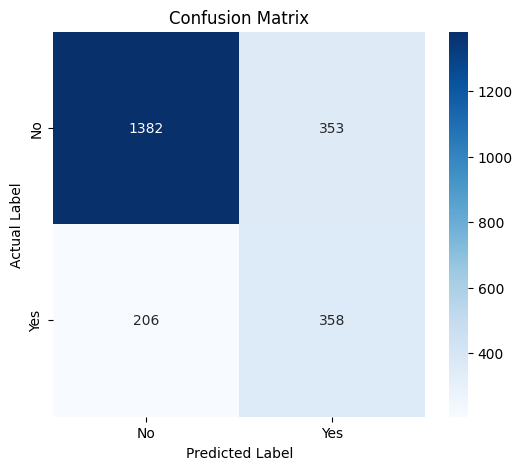

In [73]:
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

# --- STEP 1: DATA SPLITTING STRATEGY ---

# 1. Split out the FINAL Test set (20%)
xTrainFull, xTest, yTrainFull, yTest = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Create the HOLD-OUT Validation set (20% of the 80%)
xTrain, xVal, yTrain, yVal = train_test_split(
    xTrainFull, yTrainFull, test_size=0.2, random_state=42, stratify=yTrainFull
)

# --- STEP 1.5: SCALING (CRITICAL FOR SVM) ---
# SVMs calculate "distance" in space. If one feature is 1000x bigger than another,
# the SVM will break. We must scale everything to be roughly -1 to 1.

scaler = StandardScaler()

# Fit on Train, Transform the others.
# We keep them as DataFrames so we can track column names for Feature Importance.
xTrainScaled = pd.DataFrame(scaler.fit_transform(xTrain), columns=xTrain.columns, index=xTrain.index)
xValScaled = pd.DataFrame(scaler.transform(xVal), columns=xVal.columns, index=xVal.index)

# --- STEP 2: BASELINE LINEAR SVM MODEL ---

svmModel = LinearSVC(
    class_weight='balanced',   # Handles the imbalance
    C=1.0,                     # Regularization strength (1.0 is default)
    random_state=42,
    dual="auto",               # Automatically picks the best solver
    max_iter=2000              # Give it enough time to converge
)

svmModel.fit(xTrainScaled, yTrain)

# Predict Baseline
yValPred = svmModel.predict(xValScaled)
f1Val = f1_score(yVal, yValPred)

print(f"\n--- Baseline Performance (All Features) ---")
print(f"F1 Score: {f1Val:.4f}")

# --- STEP 3: VISUALISE INFORMATION GAIN ---

# SVMs don't have "feature_importances_" logic like Trees.
# Instead, they have "coefficients" (weights).
# A high absolute weight means the feature strongly pushes the data to one side of the line.

importances = np.abs(svmModel.coef_[0])

# 1. Text Print Out
feature_df = pd.DataFrame({'Feature': xTrain.columns, 'Importance': importances})
print("\n--- Top 30 Feature Importances (Absolute Coefficients) ---")
print(feature_df.sort_values(by='Importance', ascending=False).head(30))

# 2. Plotting
# We temporarily attach the importances to the model object so your plot function works
svmModel.feature_importances_ = importances
plot_feature_importance(svmModel, xTrain.columns, topN=30)

# --- STEP 3.5: MODEL SELECTION (Baseline vs. Top 30) ---

print("\n--- Comparing Baseline vs. Trimmed Model ---")

# 1. Extract Top 30 Feature Names
feature_names = xTrain.columns
sortedFeatures = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:30]
top30Features = [k for k, _ in sortedFeatures]

print(f"Top 30 Features selected: {top30Features}")

# 2. Create Trimmed Datasets (Using the SCALED data)
xTrainTrimmed = xTrainScaled[top30Features]
xValTrimmed = xValScaled[top30Features]

# 3. Train Trimmed Model
svmTrimmed = LinearSVC(
    class_weight='balanced',
    C=1.0,
    random_state=42,
    dual="auto",
    max_iter=2000
)

svmTrimmed.fit(xTrainTrimmed, yTrain)

# 4. Evaluate Trimmed
yValPredTrimmed = svmTrimmed.predict(xValTrimmed)
f1Trimmed = f1_score(yVal, yValPredTrimmed)

print(f"Baseline F1: {f1Val:.4f}")
print(f"Trimmed F1:  {f1Trimmed:.4f}")

# 5. THE DECISION SWITCH
if f1Trimmed >= (f1Val - 0.01):
    print(">>> Applying TRIMMED Model - Top 30 features")
    final_features = top30Features
else:
    print(">>> Applying BASELINE Model - All features")
    final_features = xTrain.columns

# --- STEP 4: HYPERPARAMETER TUNING (Grid Search CV) ---

print("\n--- Starting Hyperparameter Tuning (Grid Search) ---")
print(f"Tuning on {len(final_features)} features...")

# Prepare Full Data (Scale it first!)
xTrainFullScaled = pd.DataFrame(scaler.fit_transform(xTrainFull[final_features]), columns=final_features, index=xTrainFull.index)
xTestScaled = pd.DataFrame(scaler.transform(xTest[final_features]), columns=final_features, index=xTest.index)

# SVM Grid
paramGrid = {
    "C": [0.01, 0.1, 1, 10, 100],        # Main parameter: Penalty strength
    "class_weight": ["balanced", None]   # Toggle balancing
}

svmGrid = LinearSVC(
    random_state=42,
    dual="auto",
    max_iter=5000 # Increase iterations for the grid search safety
)

gridSearch = GridSearchCV(
    estimator=svmGrid,
    param_grid=paramGrid,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
)

gridSearch.fit(xTrainFullScaled, yTrainFull)

print(f"Best Parameters: {gridSearch.best_params_}")
print(f"Best CV F1 Score: {gridSearch.best_score_:.4f}")

# --- STEP 5: FINAL EVALUATION ON TEST SET ---

bestModel = gridSearch.best_estimator_
yTestPred = bestModel.predict(xTestScaled)

print("\n--- Final Test Set Performance ---")
print(f"F1 Score: {f1_score(yTest, yTestPred):.4f}")

print("\nConfusion Matrix:")
plot_confusion_matrix(yTest, yTestPred, labels=["No", "Yes"])

## Logistic Regression


--- Baseline Performance (All Features) ---
F1 Score: 0.5296

--- Top 30 Feature Importances (Absolute Coefficients) ---
                   Feature  Importance
68  city_development_index    0.971025
4                 city.104    0.500564
69     relevant_experience    0.329999
26                city.960    0.262276
13               city.2194    0.246164
65            company_size    0.243659
31                city.326    0.233225
66            company_type    0.175915
25                 city.96    0.162229
61     enrolled_university    0.143020
62         education_level    0.111458
1                  city.10    0.109127
51                 city.75    0.106579
8                 city.114    0.103991
54                 city.89    0.098674
70          training_hours    0.087529
9                city.2341    0.080113
48                city.798    0.078994
44                 city.64    0.073640
28                city.665    0.073637
32                city.323    0.073067
22               cit

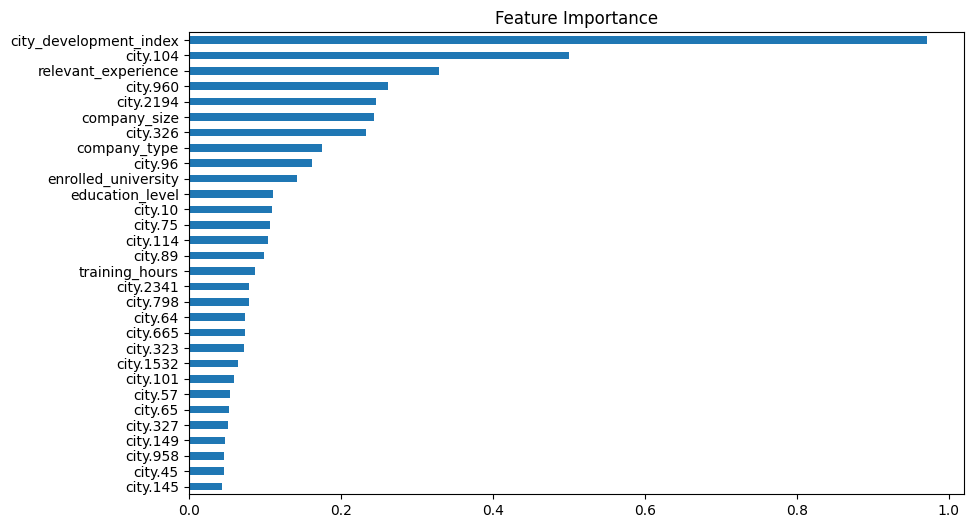


--- Comparing Baseline vs. Trimmed Model ---
Top 30 Features selected: ['city_development_index', 'city.104', 'relevant_experience', 'city.960', 'city.2194', 'company_size', 'city.326', 'company_type', 'city.96', 'enrolled_university', 'education_level', 'city.10', 'city.75', 'city.114', 'city.89', 'training_hours', 'city.2341', 'city.798', 'city.64', 'city.665', 'city.323', 'city.1532', 'city.101', 'city.57', 'city.65', 'city.327', 'city.149', 'city.958', 'city.45', 'city.145']
Baseline F1: 0.5296
Trimmed F1:  0.5292
>>> Applying TRIMMED Model - Top 30 features

--- Starting Hyperparameter Tuning (Grid Search) ---
Tuning on 30 features...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
Best CV F1 Score: 0.5496

--- Final Test Set Performance ---
F1 Score: 0.5651

Confusion Matrix:


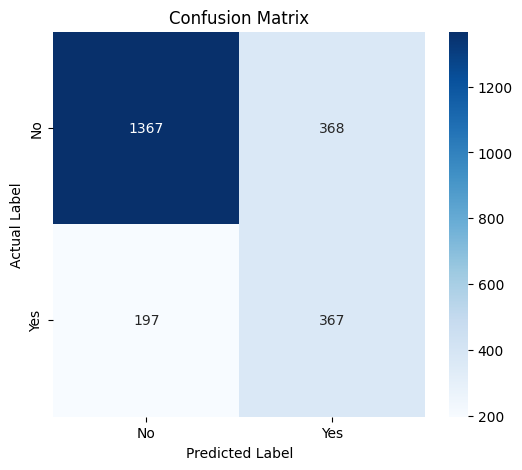

In [74]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

# --- STEP 1: DATA SPLITTING STRATEGY ---

# 1. Split out the FINAL Test set (20%)
xTrainFull, xTest, yTrainFull, yTest = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Create the HOLD-OUT Validation set (20% of the 80%)
xTrain, xVal, yTrain, yVal = train_test_split(
    xTrainFull, yTrainFull, test_size=0.2, random_state=42, stratify=yTrainFull
)

# --- STEP 1.5: SCALING (CRITICAL FOR LOG REG / SVM) ---
# Simple models require features to be on the same scale (e.g., roughly -1 to 1)

scaler = StandardScaler()

# We fit on Train, and transform Val/Test.
# We wrap in DataFrame to keep column names for Feature Importance later.
xTrainScaled = pd.DataFrame(scaler.fit_transform(xTrain), columns=xTrain.columns, index=xTrain.index)
xValScaled = pd.DataFrame(scaler.transform(xVal), columns=xVal.columns, index=xVal.index)

# Note: We will scale the Full/Test sets later in the final step

# --- STEP 2: BASELINE LOGISTIC REGRESSION MODEL ---

lrModel = LogisticRegression(
    solver='liblinear',          # Good for small-medium datasets
    class_weight='balanced',     # Handles the imbalance
    C=1.0,                       # Inverse regularization strength (smaller = stronger reg)
    random_state=42,
    max_iter=1000                # Ensure it converges
)

lrModel.fit(xTrainScaled, yTrain)

# Predict Baseline
yValPred = lrModel.predict(xValScaled)
f1Val = f1_score(yVal, yValPred)

print(f"\n--- Baseline Performance (All Features) ---")
print(f"F1 Score: {f1Val:.4f}")

# --- STEP 3: VISUALISE INFORMATION GAIN (Coefficients) ---

# Logistic Regression doesn't have "feature_importances_", it has "coefficients".
# The magnitude (absolute value) of the coefficient indicates importance.
importances = np.abs(lrModel.coef_[0])

# 1. Text Print Out
feature_df = pd.DataFrame({'Feature': xTrain.columns, 'Importance': importances})
print("\n--- Top 30 Feature Importances (Absolute Coefficients) ---")
print(feature_df.sort_values(by='Importance', ascending=False).head(30))

# 2. Plotting
# We temporarily attach the importances to the model object so your plot function works
lrModel.feature_importances_ = importances
plot_feature_importance(lrModel, xTrain.columns, topN=30)

# --- STEP 3.5: MODEL SELECTION (Baseline vs. Top 30) ---

print("\n--- Comparing Baseline vs. Trimmed Model ---")

# 1. Extract Top 30 Feature Names
feature_names = xTrain.columns
sortedFeatures = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:30]
top30Features = [k for k, _ in sortedFeatures]

print(f"Top 30 Features selected: {top30Features}")

# 2. Create Trimmed Scaled Datasets
xTrainTrimmed = xTrainScaled[top30Features]
xValTrimmed = xValScaled[top30Features]

# 3. Train Trimmed Model
lrTrimmed = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    C=1.0,
    random_state=42,
    max_iter=1000
)

lrTrimmed.fit(xTrainTrimmed, yTrain)

# 4. Evaluate Trimmed
yValPredTrimmed = lrTrimmed.predict(xValTrimmed)
f1Trimmed = f1_score(yVal, yValPredTrimmed)

print(f"Baseline F1: {f1Val:.4f}")
print(f"Trimmed F1:  {f1Trimmed:.4f}")

# 5. THE DECISION SWITCH
if f1Trimmed >= (f1Val - 0.01):
    print(">>> Applying TRIMMED Model - Top 30 features")
    final_features = top30Features
else:
    print(">>> Applying BASELINE Model - All features")
    final_features = xTrain.columns

# --- STEP 4: HYPERPARAMETER TUNING (Grid Search CV) ---

print("\n--- Starting Hyperparameter Tuning (Grid Search) ---")
print(f"Tuning on {len(final_features)} features...")

# Prepare Full Data (Scale it first!)
xTrainFullScaled = pd.DataFrame(scaler.fit_transform(xTrainFull[final_features]), columns=final_features, index=xTrainFull.index)
xTestScaled = pd.DataFrame(scaler.transform(xTest[final_features]), columns=final_features, index=xTest.index)

# Logistic Regression Grid
paramGrid = {
    "C": [0.01, 0.1, 1, 10, 100],      # Control regularization
    "penalty": ["l1", "l2"],           # Lasso vs Ridge
    "class_weight": ["balanced", None]
}

lrGrid = LogisticRegression(
    solver='liblinear',
    random_state=42,
    max_iter=2000
)

gridSearch = GridSearchCV(
    estimator=lrGrid,
    param_grid=paramGrid,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
)

gridSearch.fit(xTrainFullScaled, yTrainFull)

print(f"Best Parameters: {gridSearch.best_params_}")
print(f"Best CV F1 Score: {gridSearch.best_score_:.4f}")

# --- STEP 5: FINAL EVALUATION ON TEST SET ---

bestModel = gridSearch.best_estimator_
yTestPred = bestModel.predict(xTestScaled)

print("\n--- Final Test Set Performance ---")
print(f"F1 Score: {f1_score(yTest, yTestPred):.4f}")

print("\nConfusion Matrix:")
plot_confusion_matrix(yTest, yTestPred, labels=["No", "Yes"])